In [1]:
# import autograd functionally
import autograd.numpy as np
from autograd.misc.flatten import flatten_func
from autograd import grad as compute_grad

# import various other libraries
import matplotlib.pyplot as plt
from copy import deepcopy
# this is needed to compensate for %matplotl+ib notebook's tendancy lotted inline
from matplotlib import rcParams
rcParams["figure.autolayout"] = True
from sklearn.datasets import fetch_openml
from PIL import Image
import os

In [2]:
# gradient descent function
def gradient_descent(g, w ,alpha, max_its, beta):
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    # push the first w
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros(np.shape(w))  # momentum term

    # over the line
    for k in range(max_its):
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        # take descent step with momentum
        z = beta * z + grad_eval
        w = w -alpha * z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

def plotting(cost_hist, ylabelName, label):
    figure, axes = plt.subplots(1,1, figsize = (6,5))
    axes.plot(range(len(cost_hist)),cost_hist, label = label, linestyle = "solid")
    axes.set_xlabel("iterations")
    axes.set_ylabel(ylabelName)
    axes.legend()
    plt.show()

In [3]:
x, y = fetch_openml("mnist_784", version = 1, return_X_y = True)
y = np.array([int(v) for v in y])[np.newaxis,:].T
x_copy = deepcopy(x)
y_copy = deepcopy(y)
print(x.shape)
print(y.shape)

(70000, 784)
(70000, 1)


In [4]:
def conv(image, weight):
    height, width = image.shape
    h, w = weight.shape
    # the new size of after the conv scanning operation
    new_h = height - h + 1
    new_w = width - w + 1
    new_image = np.zeros((new_h, new_w), dtype = np.float)
    # do the conv operation
    for i in range(new_h):
        for j in range(new_w):
            new_image[i,j] = np.sum(image[i:i+h, j:j+w] * weight)
    # remove values smaller than 0 or larger than 255
    new_image = new_image.clip(0, 255)
    new_image = np.rint(new_image).astype("uint8")
    return new_image

def image_loop(images, weight):
    data = []
    for image in images:
        pic = image.reshape(int(np.size(image)**0.5),int(np.size(image)**0.5))
        pic_processed = conv(pic,weight)
        data_processed = pic_processed.flatten()
        data.append(data_processed)
    data = np.array(data)
    return data

# we use the laplacian as the weight of the edge detection
laplacian = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
# use prewitt as the weight
prewitt_v = np.array([[-1,0,1],[-1,0,1],[-1,0,1]]) 
prewitt_h = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

In [6]:
# now we should normalize the weights before
def normalization(w):
    slice = w[1:]
    norm = np.sum(np.power(slice,2),axis = 0)**0.5
    result = w/norm
    return result

def model(x,w):
    w = normalization(w)
    result = w[0] + np.dot(x, w[1:])
    return result

    
def multi_class_softmax(w):
    all_evals = model(x,w)
    # compute the exp result
    init_result = np.exp(all_evals)
    total = np.sum(init_result, axis = 1)
    # select the corresponding column
    b = init_result[np.arange(np.size(y)),y.astype(int).flatten()]
    cost = -1*np.sum(np.log(b/total))
    cost = cost + 10**-5*np.linalg.norm(w[1:],'fro')**2
    return cost/float(np.size(y))

def batch_multi_class_softmax(w):
    all_evals = model(x_batch,w)
    # compute the exp result
    init_result = np.exp(all_evals)
    total = np.sum(init_result, axis = 1)
    # select the corresponding column
    b = init_result[np.arange(np.size(y_batch)),y_batch.astype(int).flatten()]
    cost = -1*np.sum(np.log(b/total))
    cost = cost + 10**-5*np.linalg.norm(w[1:],'fro')**2
    return cost/float(np.size(y_batch))

def predict(weight):
    index = np.argmax(model(x, weight), axis = 1)
    correct_num = np.sum(np.array(index == y_true, dtype = int))
    wrong_num = np.size(y_true) - correct_num
    accuracy = correct_num/np.size(y_true)
    return wrong_num



def plotting_mis(weight_history,y_label):
    figure, axes = plt.subplots(1,1, figsize = (6,5))
    x = list(range(len(weight_history)))
    y = [predict(w) for w in weight_history]
    axes.plot(x,y, label = y_label, linestyle = "solid")
    axes.set_ylabel("misclassification_number")
    axes.set_xlabel("iterations")
    axes.legend()
    plt.show()

In [11]:
def mini_Batch(iterations):
    w_batch = np.random.randn(x.shape[1]+1, np.max(y).astype(int)+1)
    alpha = 0.02
    iterations_step = 20
    batch_size = 200
    batch_num = int(x.shape[0]/batch_size)
    w_hist = [w_batch]
    global x_batch
    global y_batch
    """
    def batch_multi_class_softmax(w):
        all_evals = model(x_batch,w)
        # compute the exp result
        init_result = np.exp(all_evals)
        total = np.sum(init_result, axis = 1)
        # select the corresponding column
        b = init_result[np.arange(np.size(y_batch)),y_batch.astype(int).flatten()]
        cost = -1*np.sum(np.log(b/total))
        cost = cost + 10**-5*np.linalg.norm(w[1:],'fro')**2
        return cost/float(np.size(y_batch))
        """
    for i in range(iterations):
        for batch_index in range(batch_num):
            x_batch = x[batch_index*batch_size:(batch_index+1)*batch_size]
            y_batch = y[batch_index*batch_size:(batch_index+1)*batch_size]
            w_batch_hist = gradient_descent(batch_multi_class_softmax, w_batch ,alpha, iterations_step, beta = 0)
            w_batch = w_batch_hist[-1]
        w_hist.append(w_batch) 
        
    return w_hist

In [13]:
x = x[:1000]
y = y[:1000]
w_history = mini_Batch(20)
cost_history = [multi_class_softmax(w) for w in w_history]

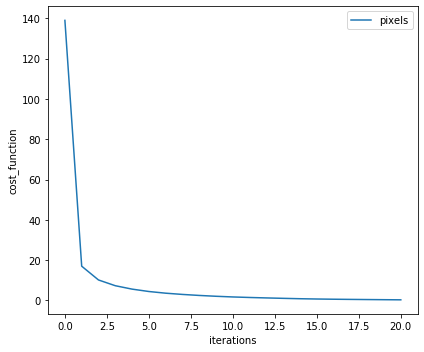

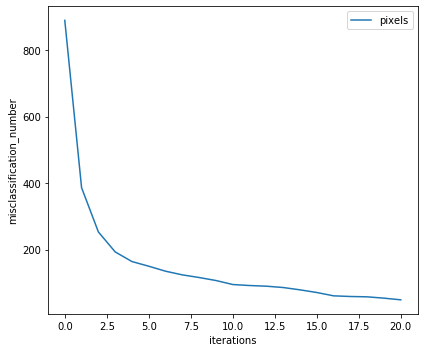

In [14]:
y_true = y.flatten()
plotting(cost_history, "cost_function", "pixels")
plotting_mis(w_history, "pixels")

In [9]:
# the weight is set prewitt_v and prewitt_h, and combine them together
x_v = image_loop(x, prewitt_v)
x_h = image_loop(x, prewitt_h)
new_image = np.rint(x_v*0.5 + x_h*0.5).astype("uint8")
x = new_image

In [10]:
w_history = mini_Batch(20)
cost_history = [multi_class_softmax(w) for w in w_history]

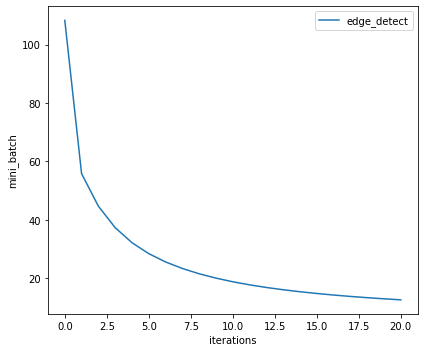

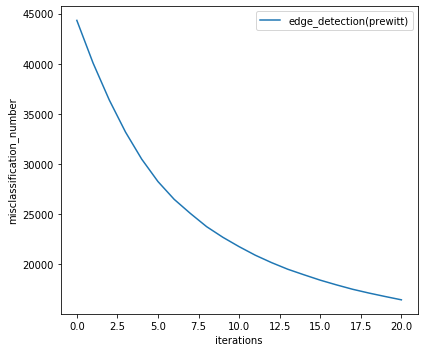

In [11]:
plotting(cost_history, "mini_batch", "edge_detect")
plotting_mis(w_history, "edge_detection(prewitt)")

In [15]:
x_v = image_loop(x_copy[50000:], prewitt_v)
x_h = image_loop(x_copy[50000:], prewitt_h)
new_image = np.rint(x_v*0.5 + x_h*0.5).astype("uint8")
x = new_image
y = y_copy[50000:]
y_true = y.flatten()

In [16]:
w_history = mini_Batch(20)
cost_history = [multi_class_softmax(w) for w in w_history]

In [17]:
# we use the remainder of 20000 as the testing, below is the misclassification
predict(w_history[-1])

5992

Conclusion: 
I write this version, measuring horizontal prewitt and vertical prewitt to do two kinds of edge detections and combine those two.
And t the feature transformation is different from that in textbook because I have scanned the whole pixels by
the kernel, so the processed feature vector has the lenght of 26*26.
Also I write minibatch by myself, afraid of that it may be not perfect compared with the labrary provided from github.
In this method, I find the original image could have nearly the same accuracy as the processed one, which has been 
shown by my final visualization.